# Figure generation for "Length Biases in Single-Cell RNA Sequencing of pre-mRNA"

This notebook generates all figures in the body and supplement of "Length Biases in Single-Cell RNA Sequencing of pre-mRNA" based on pre-computed results from *Monod*.

The notebook is fairly large, and generates some sixty figures. We have attempted to make it fairly modular. The "Prerequisites" section is required by every figure, but we do not need to go down the line and run every single cell: we can typically start at the relevant heading.

The analyses and visualizations largely reproduce the functionality in the *Monod* Python package, and heavily use its functions. All of the notebooks used *Monod* 0.2.5.0 to generate and analyze the data. For the convenience, we rewrite some of its functionality in the current notebook, so aesthetics can be modified simply by changing entries in the `aesthetics` dictionary.

## Prerequisites

Load in *Monod* and other prerequisites.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib
import matplotlib.pyplot as plt
import scipy

Define metadata for the `kb` runs.

In [4]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

Define gene length reference locations with.

In [5]:
dict_locations = ['../GP_2021_3/polyA_ref/' + x for x in ['gg_200525_genome_polyA_cum_3','gg_200524_mouse_genome_polyA_cum_1']]
transcriptome_dicts = [monod.preprocess.get_transcriptome(x) for x in dict_locations] #human then mouse

In [6]:
# !pwd

Define all aesthetics.

In [7]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


aesthetics = \
    {'selected_markersize_body':2.2,'omitted_markersize_body':1.8,
     'selected_markersize_supp':2.2,'selected_markersize_supp':1.8,
     'selected_color':np.array([212,107,75])/255,
     'omitted_color':'lightgray',
     'selected_alpha':0.3,'omitted_alpha':0.1,'fontsize_body_axes':14,'fontsize_body_title':16,
     'pmf_colormap':cmap_histogram,
     'landscape_colormap':cmap_histogram,
     'landscape_highlight_colormap':cmap_highlight_landscape,
     'optimum_color':[212/255,107/255,75/255],
     'optimum_markersize':100,
     'highlighted_optimum_markersize':300,
     'dataset_colors':('violet','darkorchid','rebeccapurple','midnightblue'),
     "accepted_gene_color": [203/255,197/255,149/255],
     "rejected_gene_color": "darkgrey",
     "accepted_gene_alpha": 0.4,
     "rejected_gene_alpha": 0.5,
     "accepted_gene_ms": 5,
     "rejected_gene_ms": 5,
     'hist_face_color':'lightgray',
     "hist_fit_color":  [59/255,131/255,130/255],
     "hist_fit_lw": 3,
     'identity_line_color':[212/255,107/255,75/255],
     'identity_lw':3,
     'v2_gene_color':[39/255]*3,
     'celltype_diffs_gene_color':[39/255]*3,
     'celltype_colors_pbmc':('orange','teal','mediumvioletred'),
     'celltype_colors_allen':('lightcoral','lightseagreen'),
     'celltype_marker_alpha':0.8,
     'celltype_diffs_gene_alpha':0.3,
     'celltype_diffs_ms':4,
     'celltype_marker_ms':60,
     'partition_line_color':'lightcoral',
}

Define figure output directory.

In [8]:
figdir = './figs'

Define the whole-dataset analyses: the *Monod* batches as well as the datasets analyzed in each batch.

This involves defining "replicate pairs," i.e., sets of samples that are mutual biological or technical replicates.

In [9]:
batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221118_025_allen_1']
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]
dataset_v2_list = ['pbmc_1k_v2','heart_1k_v2','neuron_1k_v2','allen_B05']

dataset_name_list = [['pbmc_1k_v2','pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v2','heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v2','neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]]

tenX_dir = '/home/ggorin/count_data/loom_10x_kb/'
allen_dir = '/home/ggorin/count_data/loom_allen_kb/'
raw_looms = [[tenX_dir+x+'.loom' for x in dataset_name_list[0]], \
            [tenX_dir+x+'.loom' for x in dataset_name_list[1]], \
            [tenX_dir+x+'.loom' for x in dataset_name_list[2]], \
            [allen_dir+x+'_raw.loom' for x in dataset_name_list[3]]]

batch_names = ['pbmc','heart','neuron','allen']
tech_replicate_pairs = [[[0,1]],[[0,1]],[[0,1]],[[1,4],[3,5]]]
bio_replicate_pairs = [[],[],[],[[0,1],[1,2],[2,3],[0,2],[0,3]]]
tech_v2_replicate_pairs = [[0,2],[0,2],[0,2],[0,5]]

Define batches for the analysis without a technical noise model.

In [10]:
batch_dirs_noisefree =  ['gg_221119_025_pbmc_noisefree_1',\
                         'gg_221119_025_heart_noisefree_1',\
                         'gg_221119_025_neuron_noisefree_1',\
                         'gg_221119_025_allen_noisefree_1']

Define batch metadata and marker genes for the PBMC cell type comparison.

In [11]:
pbmc_celltype_dataset = dataset_v3_list[0][1]
pbmc_baseline_dir = batch_dirs[0]
pbmc_celltype_batch_dir = 'gg_221118_025_pbmc_celltypes_1'
pbmc_celltype_names = ['Tcells','Monocytes','Bcells']
pbmc_celltype_names_labels = ['T cells','monocytes','B cells']
pbmc_celltypes = [pbmc_celltype_dataset + '_' + x for x in pbmc_celltype_names]
pbmc_markers = [['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5'],
      ['CD93','CSTA','FPR1','CD14','CD36'],
      ['CD79A','CD22','BLK','IGHD','VPREB3']]


Define batch metadata and marker genes for the Allen cell type comparison.

In [12]:
allen_celltype_datasets = dataset_v3_list[3][:4]
allen_celltype_batch_dir = 'gg_221119_025_allen_celltypes_1'
allen_celltype_names = ['Glutamatergic','GABAergic']
allen_celltype_names_labels = ['glutamatergic','GABAergic']
allen_celltypes = [[dataset + '_' + celltype for celltype in allen_celltype_names] for dataset in allen_celltype_datasets]
allen_markers = [['Slc17a7','Slc17a6'],
      ['Gad1', 'Gad2', 'Slc32a1','Slc6a5']]

Define batch metadata for the method of moments initialization benchmark.

In [13]:
MoM_batch_dir = 'gg_221120_025_pbmc_MoM_1'
MoM_dataset = dataset_v3_list[0][0]
MoM_trials = ['Bursty_Poisson_10x11_10rest','Bursty_Poisson_10x11_1rest']

Define batch metadata for the control with a length-independent technical noise model.

In [14]:
nolength_batch_dir = 'gg_221120_025_pbmc_nolengths_1'
nolength_dataset = dataset_v3_list[0][0]

In [15]:
param_names = ['Burst size','Splicing rate','Degradation rate']

# Raw means

In [16]:
def plot_spliced_unspliced_mean_bins(ax1,sd_arr,figsize=(6,6)):
    for k,sd in enumerate(sd_arr):
        q = np.quantile(sd.gene_log_lengths,np.linspace(0,1,11))
#         eps = 0.01
#         q = np.linspace(sd.gene_log_lengths.min()-eps,sd.gene_log_lengths.max()+eps,11)
        binc = q[:-1] + np.diff(q)/2
        lmU = np.log10(sd.layers[0].mean(1))
        lmS = np.log10(sd.layers[1].mean(1))
#         lmU=lmU[~np.isnan(lmU)]
#         lmS=lmS[~np.isnan(lmS)]
        
        mmU = scipy.stats.binned_statistic(sd.gene_log_lengths,lmU,'mean',q).statistic
        mmS = scipy.stats.binned_statistic(sd.gene_log_lengths,lmS,'mean',q).statistic
        stdU = scipy.stats.binned_statistic(sd.gene_log_lengths,lmU,'std',q).statistic
        stdS = scipy.stats.binned_statistic(sd.gene_log_lengths,lmS,'std',q).statistic
        
        c_nas = 'crimson'
        c_mat = 'lightslategray'
        if k>0:
            ax1.plot(binc,mmU,'-',c=c_nas,alpha=0.5,zorder=1000)
            ax1.plot(binc,mmS,'-',c=c_mat,alpha=0.5,zorder=-1000)
        else:
            ax1.plot(binc,mmU,'-',c=c_nas,alpha=0.5,zorder=1000,label='Nascent')
            ax1.plot(binc,mmS,'-',c=c_mat,alpha=0.5,zorder=-1000,label='Mature')
            


In [17]:
# batchind = 0
prefix = '../GP_2021_3/notebooks/fits/'
# sd_arr = [monod.analysis.load_search_data(prefix+batch_dirs[batchind]+'/'+x+'/raw.sd') for x in dataset_v3_list[batchind]]

In [18]:
#takes a bit of time to load raw
sd_arr = [monod.analysis.load_search_data(prefix+batch_dirs[batchind]+'/'+x+'/raw.sd') 
             for batchind in range(4) for x in dataset_v3_list[batchind]]


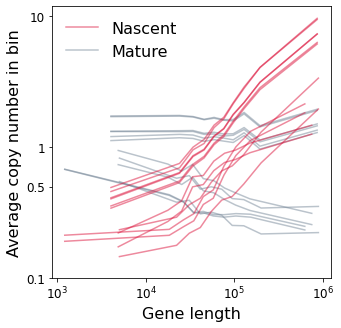

In [19]:
fig1, ax1 = plt.subplots(1,1,figsize=(5,5))
plot_spliced_unspliced_mean_bins(ax1,sd_arr)
ax1.set_xticks([3,4,5,6],[rf'$10^{x}$' for x in range(3,7)],fontsize=12)
ax1.set_xlabel('Gene length',fontsize=16)
ax1.set_yticks([np.log10(0.1),np.log10(0.5),0,1],(['0.1','0.5','1','10']),fontsize=12)
ax1.set_ylabel('Average copy number in bin',fontsize=16)
ax1.legend(frameon=False,fontsize=16)
plt.savefig('figs/fig5c.png',dpi=450)
plt.savefig('figs/fig5c.pdf')

In [20]:
prefix = '../GP_2021_3/notebooks/fits/'


In [21]:
# sr_arr_nf = [monod.analysis.load_search_results(prefix+batch_dirs_noisefree[batchind]+'/'+x+'/Bursty_None_1x1/grid_scan_results_upd.res') 
#              for batchind in range(4) for x in dataset_v3_list[batchind]]


In [22]:
def plot_burstsize_bins(sr_arr,ax1=None,col='darkgray',zorder=-1000,label='No technical noise',figsize=(6,6)):
    if ax1 is None:
        fig1, ax1 = plt.subplots(1,1,figsize=figsize)

    for k,sr in enumerate(sr_arr):
        q = np.quantile(sr.gene_log_lengths,np.linspace(0,1,11))
        binc = q[:-1] + np.diff(q)/2
        bs = sr.phys_optimum[~sr.rejected_genes,0]
#         lmU = np.log10(sd.layers[0].mean(1))
#         lmS = np.log10(sd.layers[1].mean(1))
        
        mmB = scipy.stats.binned_statistic(sr.gene_log_lengths[~sr.rejected_genes],bs,'mean',q).statistic
        
        if k>0:
            ax1.plot(binc,mmB,'-',color=col,alpha=0.5,zorder=zorder)
        else:
            ax1.plot(binc,mmB,'-',color=col,alpha=0.5,zorder=zorder,label=label)
            


In [63]:
for k in range(4):
    x=np.corrcoef(sr_arr_nf[k].gene_log_lengths[~sr_arr_nf[k].rejected_genes],
                sr_arr_nf[k].phys_optimum[~sr_arr_nf[k].rejected_genes,0])[0,1]
    print(x)

0.4532944022311802
0.5018569772235563
0.4505720122004201
0.5108632361993678


In [23]:
sr_arr_nf = [monod.analysis.load_search_results(prefix+batch_dirs_noisefree[batchind]+'/'+x+'/Bursty_None_1x1/grid_scan_results_upd.res') 
             for batchind in range(4) for x in dataset_v3_list[batchind]]
sr_arr = [monod.analysis.load_search_results(prefix+batch_dirs[batchind]+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res') 
             for batchind in range(4) for x in dataset_v3_list[batchind]]


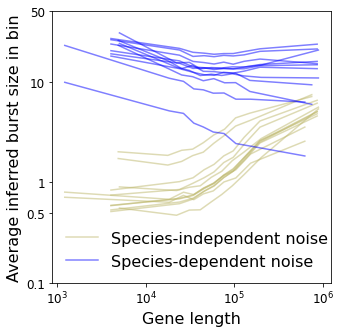

In [24]:
figsize=(5,5)
fig1, ax1 = plt.subplots(1,1,figsize=figsize)
plot_burstsize_bins(sr_arr_nf,ax1,'darkkhaki',label='Species-independent noise')
plot_burstsize_bins(sr_arr,ax1,'b',1000,label='Species-dependent noise')

ax1.set_xticks([3,4,5,6],[rf'$10^{x}$' for x in range(3,7)],fontsize=12)
ax1.set_xlabel('Gene length',fontsize=16)
ax1.set_yticks([np.log10(0.1),np.log10(0.5),0,1,np.log10(50)],(['0.1','0.5','1','10','50']),fontsize=12)
ax1.set_ylabel('Average inferred burst size in bin',fontsize=16)
ax1.legend(frameon=False,fontsize=16)
plt.savefig('figs/fig5d.png',dpi=450)
plt.savefig('figs/fig5d.pdf')

In [30]:
genelists = [np.loadtxt(y,delimiter=',',dtype=str) for y in [prefix+x+'/genes.csv' for x in batch_dirs]]

In [34]:
from pybiomart import Server
server = Server(host='http://www.ensembl.org')
human_dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl'])
mouse_dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mmusculus_gene_ensembl'])

human_query = human_dataset.query(attributes=['external_gene_name', 'transcript_length','start_position','end_position'])
mouse_query = mouse_dataset.query(attributes=['external_gene_name', 'transcript_length','start_position','end_position'])

human_query=human_query.set_index('Gene name')
mouse_query=mouse_query.set_index('Gene name')

## Human PBMC

In [38]:
tl_pbmc = []
tl_longest_pbmc = []
gl_pbmc = []
for gene in genelists[0]:
    try:
        tl_pbmc.append(human_query.loc[gene]['Transcript length (including UTRs and CDS)'].mean())
        tl_longest_pbmc.append(human_query.loc[gene]['Transcript length (including UTRs and CDS)'].max())
        gl_pbmc.append((human_query.loc[gene]['Gene end (bp)']-human_query.loc[gene]['Gene start (bp)']).max())
    except:
        pass

## Mouse heart

In [42]:
tl_heart = []
tl_longest_heart = []
gl_heart = []
for gene in genelists[1]:
    try:
        tl_heart.append(mouse_query.loc[gene]['Transcript length (including UTRs and CDS)'].mean())
        tl_longest_heart.append(mouse_query.loc[gene]['Transcript length (including UTRs and CDS)'].max())
        gl_heart.append((mouse_query.loc[gene]['Gene end (bp)']-mouse_query.loc[gene]['Gene start (bp)']).max())
    except:
        pass

In [43]:
tl_neuron = []
tl_longest_neuron = []
gl_neuron = []
for gene in genelists[2]:
    try:
        tl_neuron.append(mouse_query.loc[gene]['Transcript length (including UTRs and CDS)'].mean())
        tl_longest_neuron.append(mouse_query.loc[gene]['Transcript length (including UTRs and CDS)'].max())
        gl_neuron.append((mouse_query.loc[gene]['Gene end (bp)']-mouse_query.loc[gene]['Gene start (bp)']).max())
    except:
        pass

In [44]:
tl_allen = []
tl_longest_allen = []
gl_allen = []
for gene in genelists[3]:
    try:
        tl_allen.append(mouse_query.loc[gene]['Transcript length (including UTRs and CDS)'].mean())
        tl_longest_allen.append(mouse_query.loc[gene]['Transcript length (including UTRs and CDS)'].max())
        gl_allen.append((mouse_query.loc[gene]['Gene end (bp)']-mouse_query.loc[gene]['Gene start (bp)']).max())
    except:
        pass

In [49]:
tls = [tl_pbmc,tl_heart,tl_neuron,tl_allen]
tls_longest = [tl_longest_pbmc,tl_longest_heart,tl_longest_neuron,tl_longest_allen]
gls = [gl_pbmc,gl_heart,gl_neuron,gl_allen]

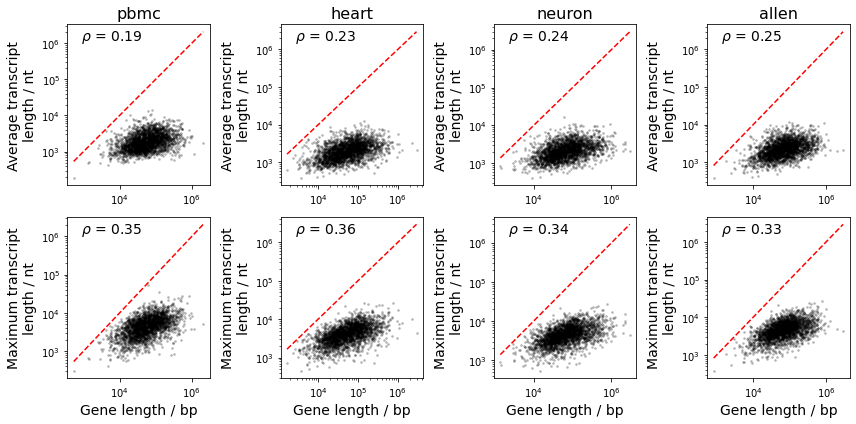

In [72]:
fig1, ax1 = plt.subplots(2,4,figsize=(12,6))

fs = 14
for k in range(4):
    ax1[0,k].scatter(gls[k],tls[k],3,'k',alpha=0.2)
    xl = [min(gls[k]),max(gls[k])]
    ax1[0,k].plot(xl,xl,'r--')
    ax1[0,k].set_xscale('log')
    ax1[0,k].set_yscale('log')
    
    ax1[1,k].scatter(gls[k],tls_longest[k],3,'k',alpha=0.2)
    ax1[1,k].plot(xl,xl,'r--')
    ax1[1,k].set_xscale('log')
    ax1[1,k].set_yscale('log')

    ax1[0,k].set_ylabel('Average transcript\nlength / nt',fontsize=fs)
    ax1[1,k].set_ylabel('Maximum transcript\nlength / nt',fontsize=fs)
    ax1[1,k].set_xlabel('Gene length / bp',fontsize=fs)
    ax1[0,k].set_title(batch_names[k],fontsize=16)
    
    x = np.corrcoef(gls[k],tls[k])[0,1]
    ax1[0,k].text(0.1,0.9,r'$\rho$ = {:.2f}'.format(x),transform=ax1[0,k].transAxes,fontsize=fs)
    x = np.corrcoef(gls[k],tls_longest[k])[0,1]
    ax1[1,k].text(0.1,0.9,r'$\rho$ = {:.2f}'.format(x),transform=ax1[1,k].transAxes,fontsize=fs)

fig1.tight_layout()
plt.savefig('figs/genelengths.png',dpi=450)
plt.savefig('figs/genelengths.pdf')

In [75]:
for k in range(4):
    x = np.corrcoef(np.log10(gls[k]),np.log10(tls[k]))[0,1]

    print(x)


0.3807895181492141
0.4479385726959466
0.43767680675819626
0.4392934348436033


In [74]:
for k in range(4):
    x = np.corrcoef(np.log10(gls[k]),np.log10(tls_longest[k]))[0,1]
    print(x)


0.5292438234659911
0.5509598450290735
0.514384136075032
0.5225706401057888


In [73]:
gls

[[282017,
  110266,
  29125,
  225992,
  18190,
  26823,
  124891,
  270948,
  38938,
  54972,
  37174,
  95964,
  141782,
  49760,
  148407,
  189226,
  134485,
  41091,
  91273,
  26553,
  50644,
  41763,
  76443,
  48331,
  95735,
  51811,
  32187,
  37220,
  33573,
  55930,
  66833,
  196585,
  89279,
  146764,
  370993,
  152951,
  27406,
  28734,
  20397,
  27083,
  206469,
  39518,
  50205,
  15401,
  56770,
  39340,
  109741,
  16504,
  27423,
  32380,
  22283,
  23040,
  405861,
  5465,
  4111,
  60809,
  33190,
  25305,
  44377,
  49518,
  49376,
  74425,
  29557,
  58905,
  55187,
  24773,
  45708,
  984252,
  12655,
  46770,
  24363,
  46982,
  105308,
  65610,
  9085,
  47057,
  34517,
  23222,
  60219,
  153349,
  37035,
  48733,
  100277,
  25270,
  64670,
  51586,
  7400,
  21387,
  32727,
  145418,
  43476,
  17685,
  41565,
  88868,
  164067,
  14142,
  582065,
  51979,
  17235,
  34921,
  20349,
  26132,
  32952,
  130920,
  175276,
  55443,
  496524,
  16580,
  1079